In [1]:
#use L-2 MODIS A DATA 
#in accordance with Fang et al. 2018 
#Algorithim for CDOM and DOC that semms good 
import xarray as xr # top library for manipulating netcdf files
import netCDF4 # more basic library for manipulating netcdf files, used for exploring
import glob #to get file names
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
import cmocean
import cmocean.cm as cmo
from glob import glob
%matplotlib inline

PART ONE MAPS

In [2]:
#uncomment the file group you want for the maps 

#filenames = glob('../../SAT_DATA/NC/GOM21FA_MODIS_Level-2/*OC*.nc')
#filenames = glob('../../SAT_DATA/NC/GOM22SP_MODIS_Level-2/*OC*.nc')
#filenames = glob('../../SAT_DATA/NC/GOM22SU_MODIS_Level-2/*OC*.nc')

filenames = glob('../../SAT_DATA/NC/GOM*/*OC*.nc')
filenames.sort()
filenames

['../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211024T180001.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211024T180501.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211024T194001.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T184500.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T202000.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T202500.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211026T192501.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211026T193001.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T183001.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T183501.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T201001.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211028T191500.L2.OC

In [3]:
#select a file to test 

path = filenames[4]

In [4]:
#make funtion to open file and save attributes 

def load_satdata(path):
    data = xr.open_dataset(path, group='geophysical_data')
    navigation = xr.open_dataset(path, group='navigation_data')
    navigation = navigation.rename({'pixel_control_points': 'pixels_per_line'})
    mask = (~navigation['latitude'].isnull()) & (~navigation['longitude'].isnull())
    data = data.where(mask, drop=True)
    data['lat'] = navigation['latitude'].where(mask, drop=True)
    data['lon'] = navigation['longitude'].where(mask, drop=True)
    atts = xr.open_dataset(path)
    time_start = atts.time_coverage_start
    data.attrs['time_start'] = time_start
    data.attrs['date'] = time_start[0:10]
    return data

ds = load_satdata(path)
ds

<xarray.Dataset>
Dimensions:   (number_of_lines: 595, pixels_per_line: 202)
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables: (12/22)
    aot_869   (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    angstrom  (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    Rrs_412   (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    Rrs_443   (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    Rrs_469   (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    Rrs_488   (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    ...        ...
    ipar      (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    nflh      (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    par       (number_of_lines, pixels_per_line) float32 nan nan nan ... nan nan
    l2_flags  (number_of_lines, pixels_per_line) float64 1.074e+09 ... 1.074e+09
    lat       (number_of_lines, pixels_per_line) float32 17.45 17.45 ... 22.2
    lon       (number_of_lines, pixels_per_line) float32 -93.52 ... -99.96
Attributes:
    time_start:  2021-10-25T20:20:00.972Z
    date:        2021-10-25

In [5]:
#make funtion to make the vars we need for maps   

def make_vars(ds):

    #HERE WE CALCUTE CDOM WITH THE ALGORITHUM WITH 
    #Mannino et al. 2015
    
    B0 = 0.2581; B1 = 1.583; B2 = 24.87
    aCDOM275_a = (np.log((ds['Rrs_412']/ds['Rrs_555'] - B0)/ B2))/(-B1)
    aCDOM275_a = aCDOM275_a.compute()
    ds['aCDOM275_a'] = aCDOM275_a
    
    B0 = 0.2452; B1 = 5.576; B2 = 4.838
    aCDOM355_a = (np.log((ds['Rrs_412']/ds['Rrs_555'] - B0)/ B2))/(-B1)
    aCDOM355_a = aCDOM355_a.compute()
    ds['aCDOM355_a'] = aCDOM355_a
    
    B0 = 0.2492; B1 = 8.689; B2 = 4.608
    aCDOM380_a = (np.log((ds['Rrs_412']/ds['Rrs_555'] - B0)/ B2))/(-B1)
    aCDOM380_a = aCDOM380_a.compute()
    ds['aCDOM380_a'] = aCDOM380_a
    
    B0 = 0.2487; B1 = 14.028; B2 = 4.085
    aCDOM412_a = (np.log((ds['Rrs_412']/ds['Rrs_555'] - B0)/ B2))/(-B1)
    aCDOM412_a = aCDOM412_a.compute()
    ds['aCDOM412_a'] = aCDOM412_a
    
    B0 = 0.2479; B1 = 23.40; B2 = 3.770
    aCDOM443_a = (np.log((ds['Rrs_412']/ds['Rrs_555'] - B0)/ B2))/(-B1)
    aCDOM443_a = aCDOM443_a.compute()
    ds['aCDOM443_a'] = aCDOM443_a
    
    B0 = 0.9925; B1 = 2.054; B2 = 634.2
    aCDOM275_b = (np.log((ds['Rrs_412']/ds['Rrs_667'] - B0)/ B2))/(-B1)
    aCDOM275_b = aCDOM275_b.compute()
    ds['aCDOM275_b'] = aCDOM275_b
    
    B0 = 0.8569; B1 = 7.661; B2 = 91.97
    aCDOM355_b = (np.log((ds['Rrs_412']/ds['Rrs_667'] - B0)/ B2))/(-B1)
    aCDOM355_b = aCDOM355_b.compute()
    ds['aCDOM355_b'] = aCDOM355_b
    
    B0 = 0.865; B1 = 11.55; B2 = 79.16
    aCDOM380_b = (np.log((ds['Rrs_412']/ds['Rrs_667'] - B0)/ B2))/(-B1)
    aCDOM380_b = aCDOM380_b.compute()
    ds['aCDOM380_b'] = aCDOM380_b
    
    B0 = 0.8625; B1 = 18.44; B2 = 62.89
    aCDOM412_b = (np.log((ds['Rrs_412']/ds['Rrs_667'] - B0)/ B2))/(-B1)
    aCDOM412_b = aCDOM412_b.compute()
    ds['aCDOM412_b'] = aCDOM412_b
    
    B0 = 0.8502; B1 = 30.53; B2 = 54.78
    aCDOM443_b = (np.log((ds['Rrs_412']/ds['Rrs_667'] - B0)/ B2))/(-B1)
    aCDOM443_b = aCDOM443_b.compute()
    ds['aCDOM443_b'] = aCDOM443_b
    
    #HERE WE CALCUTE CDOM WITH THE ALGORITHUM WITH 
    #Coa et al. 2018
    
    Rss443 = ds['Rrs_443']
    Rss448 = ds['Rrs_488']
    Rss531 = ds['Rrs_531']
    Rss555 = ds['Rrs_555']
    Rss667 = ds['Rrs_667']
    
    #calculate aCDOM 300
    aCDOM300 = (-0.0206*Rss443) + (-0.6128*Rss448) + (-0.0070*Rss531) + (-0.4944*Rss555) + (0.9362*Rss667) + (.9666)
    aCDOM300 = aCDOM300.compute()
    ds['aCDOM300'] = aCDOM300

    #calculate aCDOM 355
    aCDOM355 = (0.0376*Rss443) + (-0.8714*Rss448) +(-0.0352*Rss531) + (-0.2739*Rss555) + (0.9591*Rss667) + (-0.1071)
    aCDOM355 = aCDOM355.compute()
    ds['aCDOM355'] = aCDOM355

    #calculate aCDOM SS 275-295
    aCDOMss = (-0.0537*Rss443) + (0.2689*Rss448) + (0.1017*Rss531) + (-0.2097*Rss555) + (-0.0893*Rss667) + (-3.6853)
    aCDOMss = aCDOMss.compute()
    ds['aCDOMss'] = aCDOMss
    
    #calculate DOC
    #DOC = aCDOM300 / ((np.exp(-15.05-(33.95*aCDOMss)))+(np.exp(-1.502-(104.3*aCDOMss)))) 
    TERM1 = (-15.05-(33.95*aCDOMss))
    TERM2 = (-1.502-(04.3*aCDOMss))
    # np.logaddexp Calculates log(exp(x1) + exp(x2))
    TERM = np.logaddexp(TERM1, TERM2)
    DOC = aCDOM300/(TERM) 
    DOC = DOC.compute()
    ds['DOC'] = DOC

    return ds

ds = make_vars(ds)
ds

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)


<xarray.Dataset>
Dimensions:     (number_of_lines: 595, pixels_per_line: 202)
Dimensions without coordinates: number_of_lines, pixels_per_line
Data variables: (12/36)
    aot_869     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    angstrom    (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_412     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_443     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_469     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    Rrs_488     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    ...          ...
    aCDOM412_b  (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOM443_b  (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOM300    (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOM355    (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    aCDOMss     (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
    DOC         (number_of_lines, pixels_per_line) float32 nan nan ... nan nan
Attributes:
    time_start:  2021-10-25T20:20:00.972Z
    date:        2021-10-25

In [7]:
#making the map

lat_top=31
lat_bot=25
lon_left=-85
lon_rigth=-95
extent=[lon_left, lon_rigth, lat_bot, lat_top]

def plot_mapbase(extent, res='10m', projection=ccrs.PlateCarree()):
    fig = plt.figure(figsize=(10,5)) # set fig size
    ax = fig.add_subplot(111, projection=projection)
    ax.set_extent(extent)
    ax.coastlines(res)
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='land',
                                                facecolor='grey', # change color here
                                                scale=res)) 
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', 
                                                name='rivers_lake_centerlines',
                                                edgecolor='blue', # change color here
                                                facecolor='none',
                                                scale=res))
    gl = ax.gridlines(xlocs=np.arange(lon_left, lon_rigth+1),
                      ylocs=np.arange(lat_bot, lat_top+1),
                      draw_labels=True, 
                      linewidth=0.5, color='k', linestyle=':')
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 15, 'color': 'black'}
    gl.ylabel_style = {'size': 15, 'color': 'black'}
    return fig, ax

In [8]:
#making the map

params = {"ytick.color" : "black",
          "xtick.color" : "black",
          "axes.labelcolor" : "black",
          "axes.edgecolor" : "black"}
plt.rcParams.update(params)

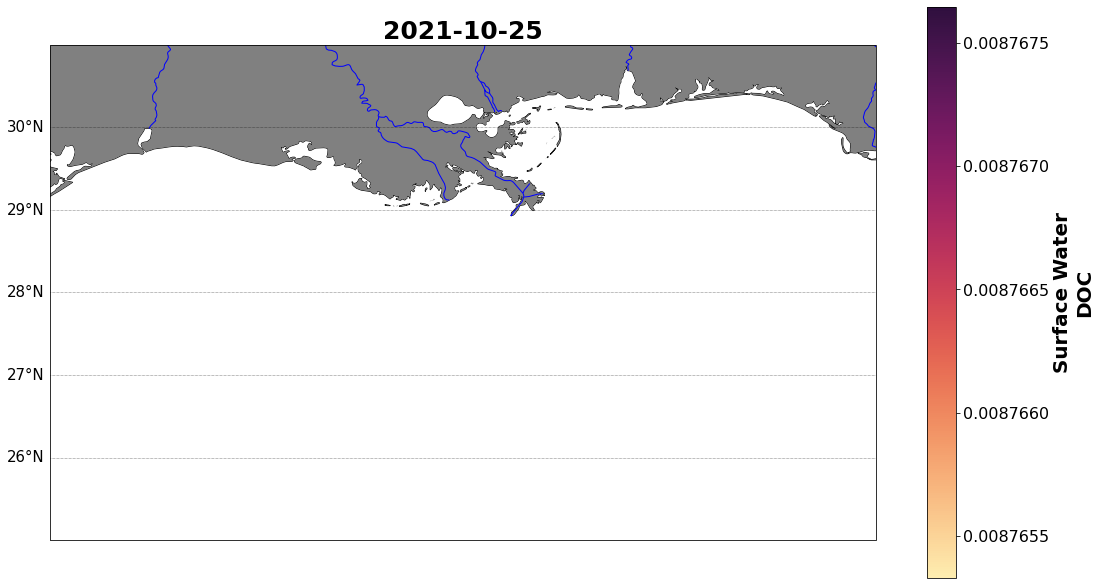

In [9]:
#making the map for the test file 

fig, ax = plot_mapbase(extent)
satdata = ax.pcolormesh(ds['lon'], ds['lat'], ds['DOC'], cmap=cmo.matter, transform=ccrs.PlateCarree())
cb = fig.colorbar(satdata)
cb.ax.tick_params(labelcolor='black') 
cb.set_label('Surface Water\n'+'DOC', size=20, weight='bold', color='black')
tick_font_size = 16
cb.ax.tick_params(labelsize=tick_font_size)
ax.set_title(ds.attrs['date'], color='black', size=25, weight='bold',)
fig.set_size_inches(18.5, 10.5)

In [10]:
#pull meta data on what we need 
df = pd.read_csv('../../SAT_DATA/Data_other/Sat_data_lat_lon_date.csv')
df = df.dropna(axis=0, how='all')
df['Date'] = pd.to_datetime(df['Date'])
Dates = df['Date'].to_string()
df['Date_ST'] = df['Date'].astype(str)
df

Sample       Date     Trip  Station        Lat        Lon  Water_dapth  \
0   222338.0 2022-04-20  GOM22SP     St.4  28.798590 -90.706616         19.0   
1   222339.0 2022-04-20  GOM22SP     St.4  28.798590 -90.706616         19.0   
2   222238.0 2022-04-19  GOM22SP    St.MK  28.907780 -90.309226         20.2   
3   222239.0 2022-04-19  GOM22SP    St.MK  28.907780 -90.309226         20.2   
4   222137.0 2022-04-18  GOM22SP    St.13  28.519041 -89.887250        577.0   
..       ...        ...      ...      ...        ...        ...          ...   
83  214739.0 2021-10-30  GOM21FA  St.MK-2  28.571700 -90.196010         13.3   
84  214740.0 2021-10-30  GOM21FA  St.MK-2  28.571700 -90.196010         13.3   
85  225338.0 2022-07-23  GOM22SU    St.MK        NaN        NaN         17.5   
86  225139.0 2022-07-20  GOM22SU    St.16        NaN        NaN         57.2   
87  224938.0 2022-07-19  GOM22SU     St.2        NaN        NaN         62.0   

    Sample_depth                                              Notes  Flagged  \
0           0.00  Misslables as MK on the bag. But the sample nu...      NaN   
1           0.00  Misslables as MK on the bag. But the sample nu...      NaN   
2           0.00                                                NaN      NaN   
3           0.00                                                NaN      NaN   
4           0.00                                                NaN      NaN   
..           ...                                                ...      ...   
83          2.10                                                NaN      NaN   
84          2.10                                                NaN      NaN   
85          2.48                                                NaN      NaN   
86          2.80                                                NaN      NaN   
87          2.80                                                NaN      NaN   

       Date_ST  
0   2022-04-20  
1   2022-04-20  
2   2022-04-19  
3   2022-04-19  
4   2022-04-18  
..         ...  
83  2021-10-30  
84  2021-10-30  
85  2022-07-23  
86  2022-07-20  
87  2022-07-19  

[88 rows x 11 columns]

In [11]:
type(df['Date_ST'][0])

str

In [12]:
files_needed = []  

for file in filenames: 
    path = file 
    ds = load_satdata(path)
    if ds.attrs['date'] in Dates:
        files_needed.append(file)

files_needed

['../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T184500.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T202000.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211025T202500.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211026T192501.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211026T193001.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T183001.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T183501.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211027T201001.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211030T190001.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211030T190501.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211031T180500.L2.OC.x.nc',
 '../../SAT_DATA/NC\\GOM21FA_MODIS_Level-2\\AQUA_MODIS.20211031T181001.L2.OC

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  

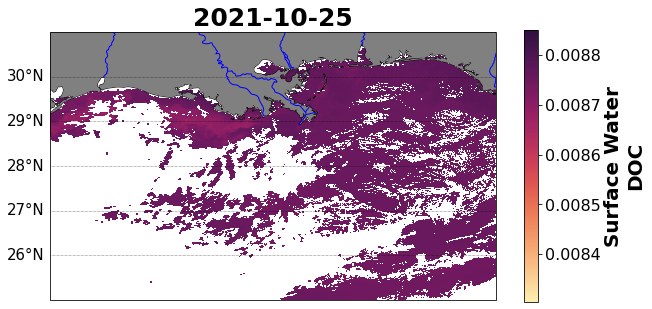

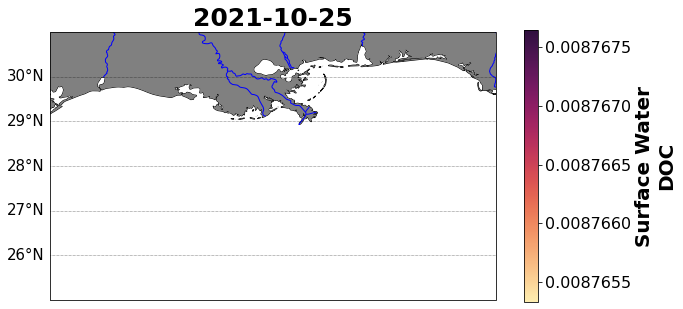

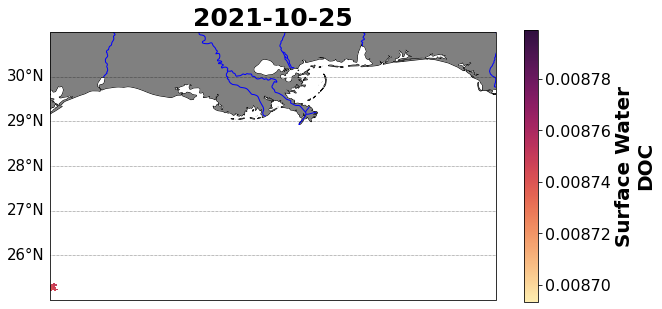

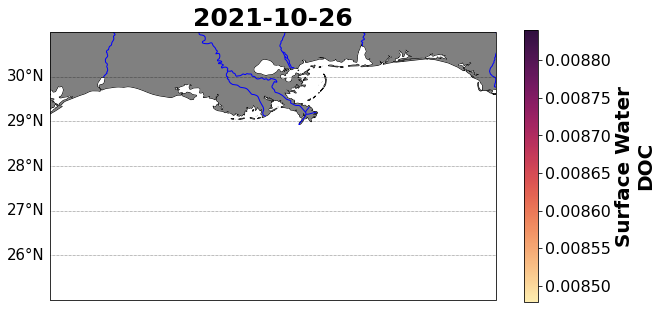

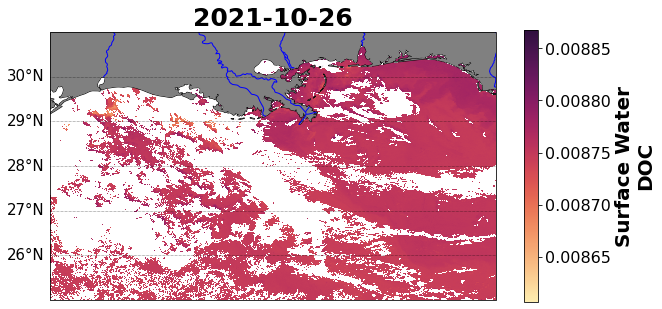

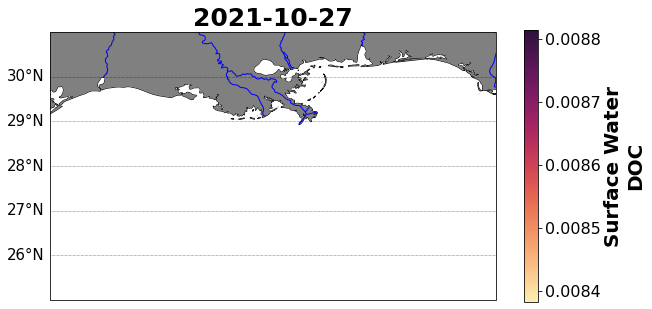

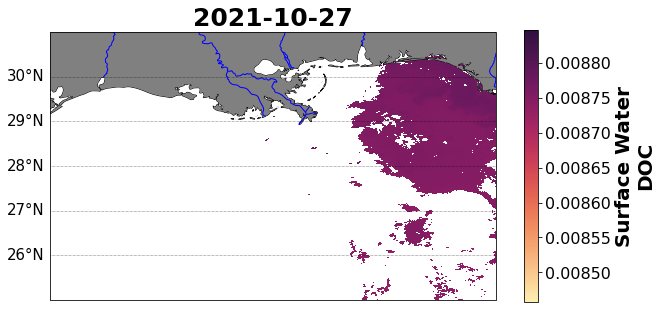

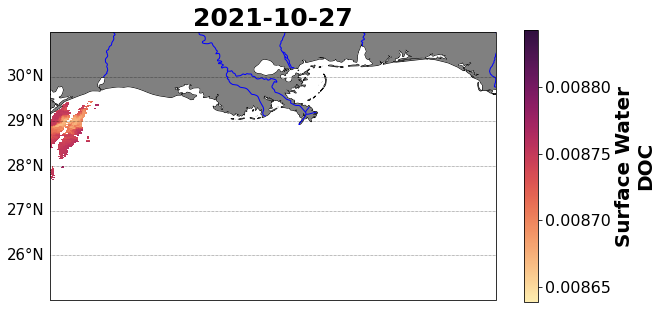

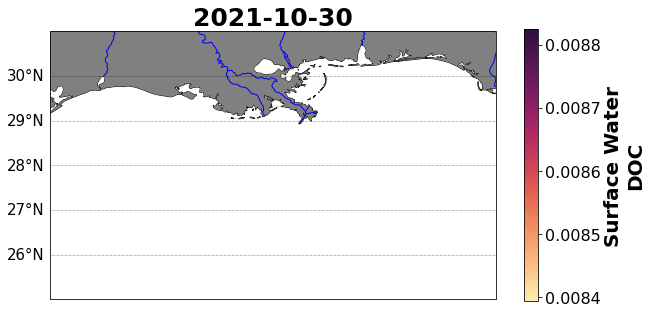

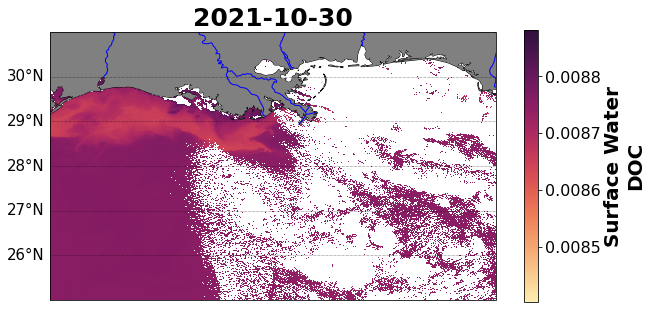

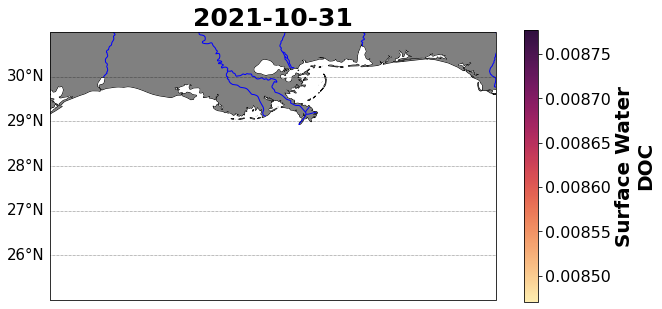

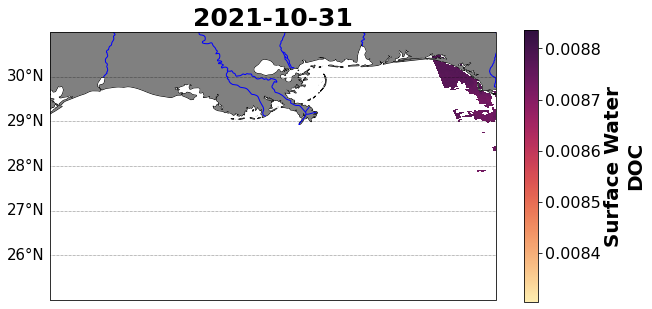

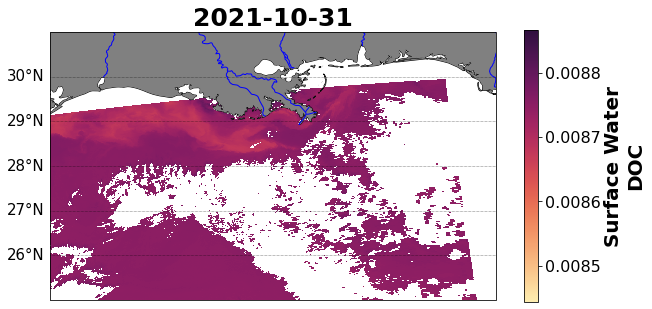

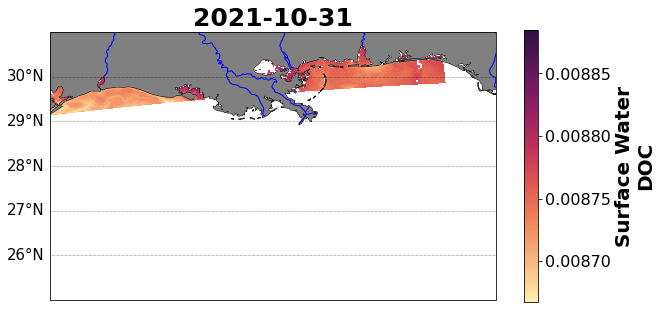

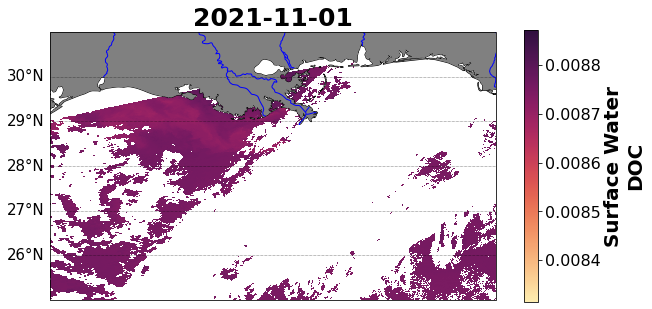

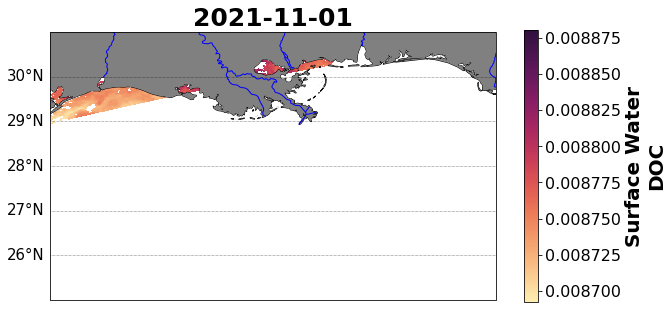

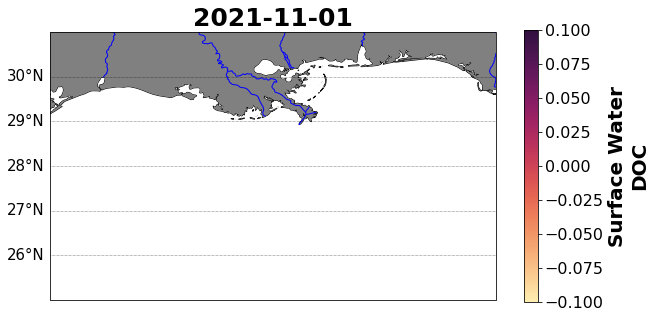

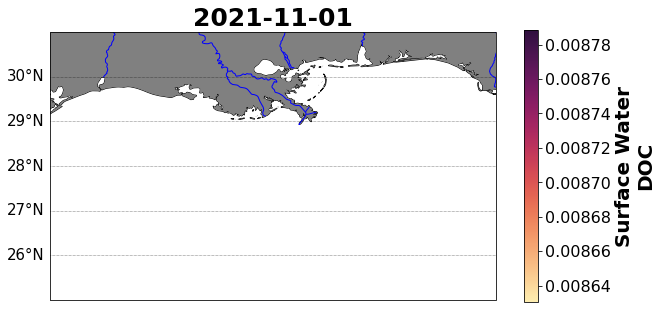

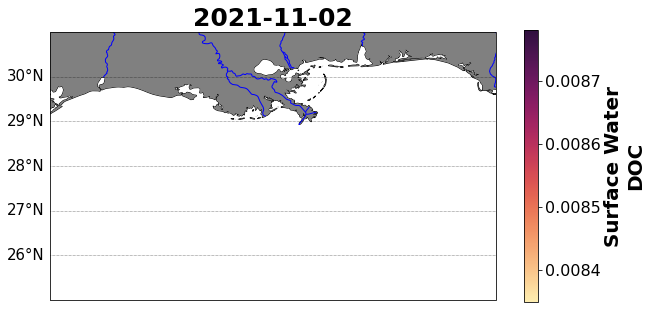

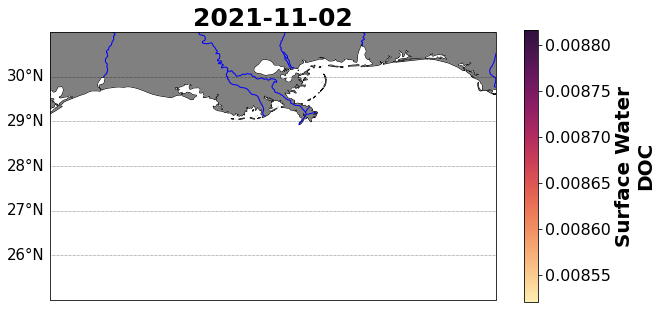

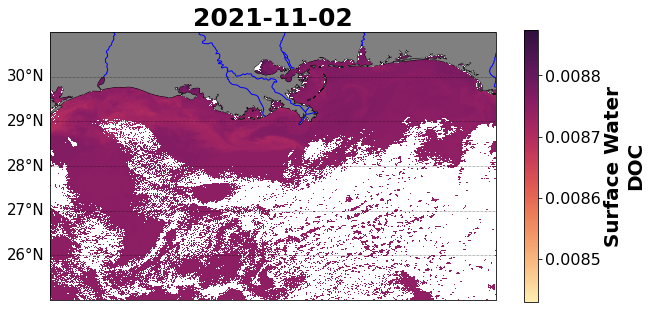

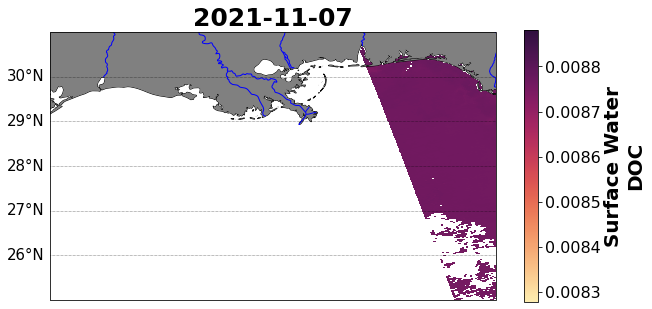

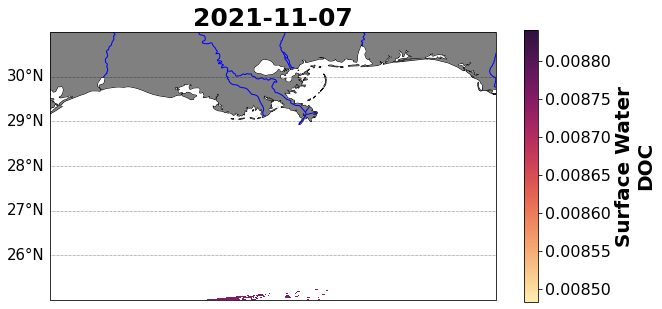

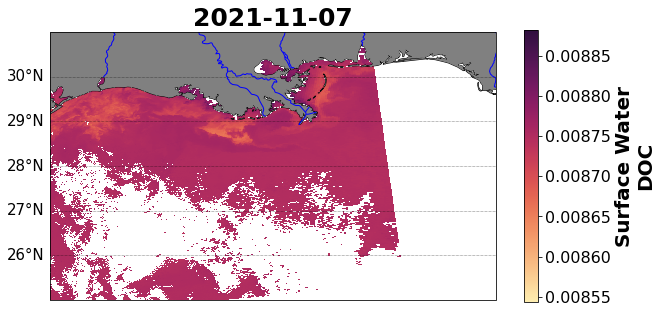

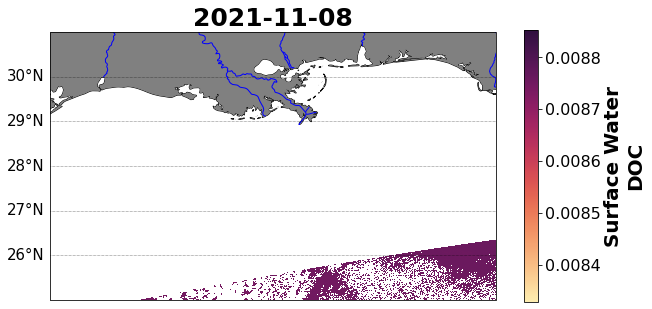

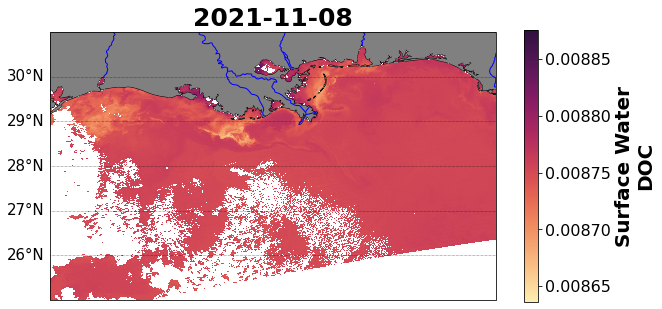

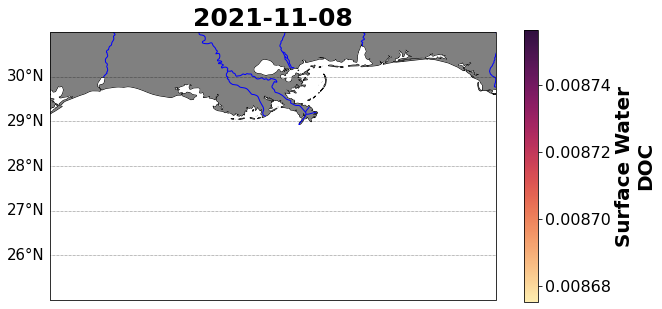

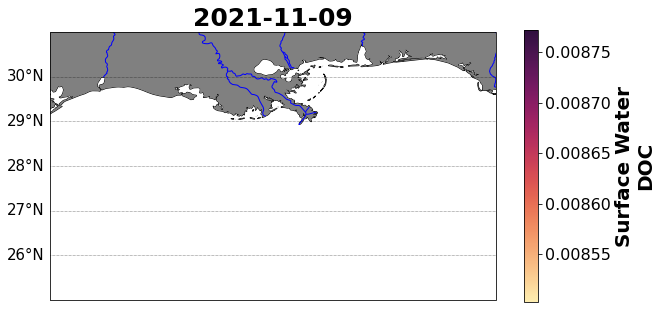

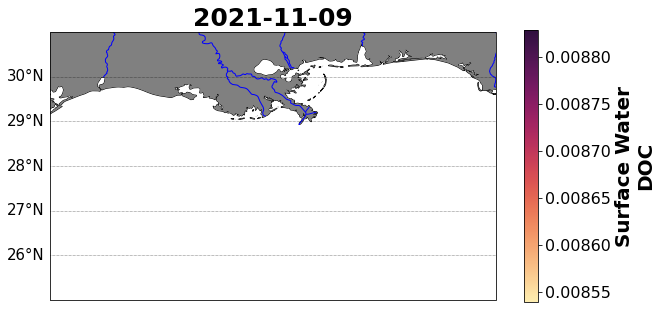

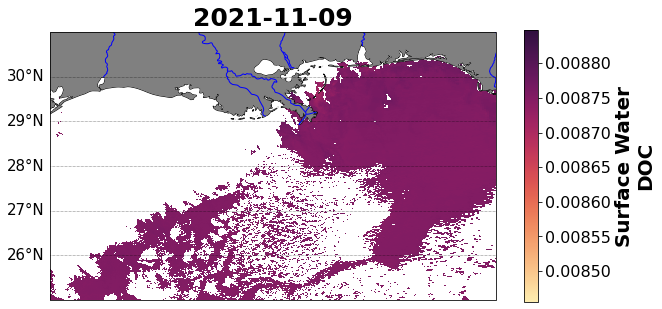

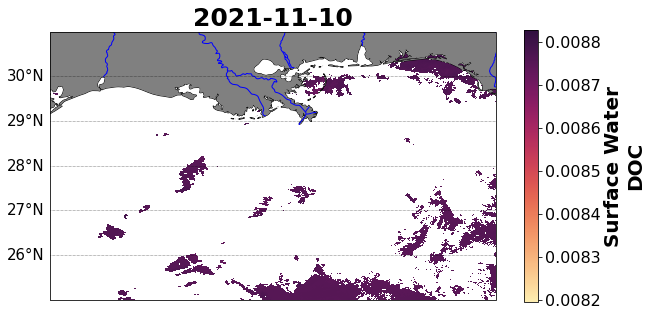

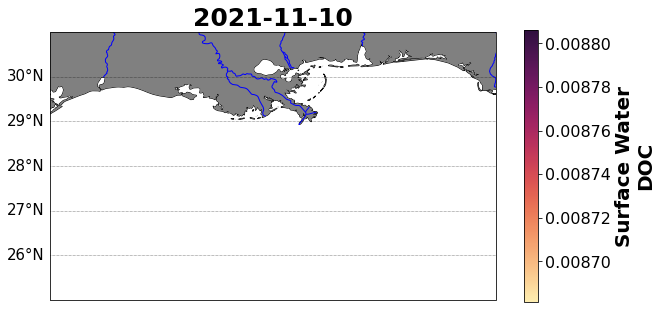

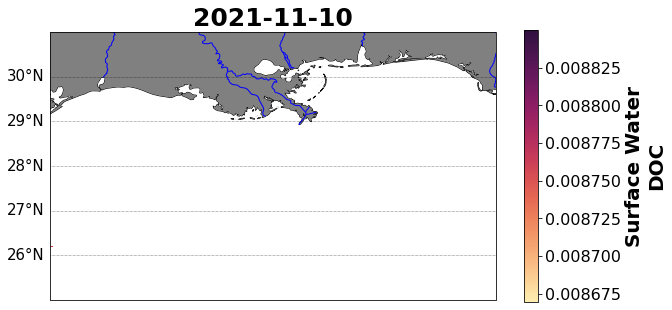

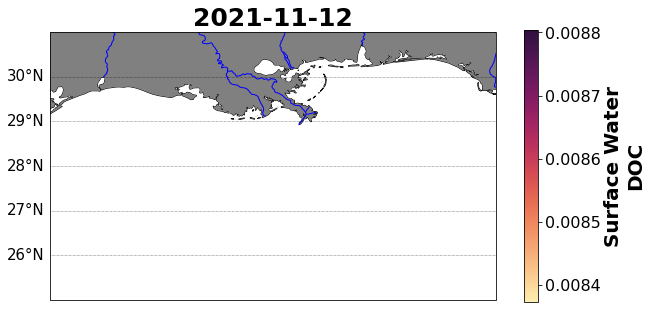

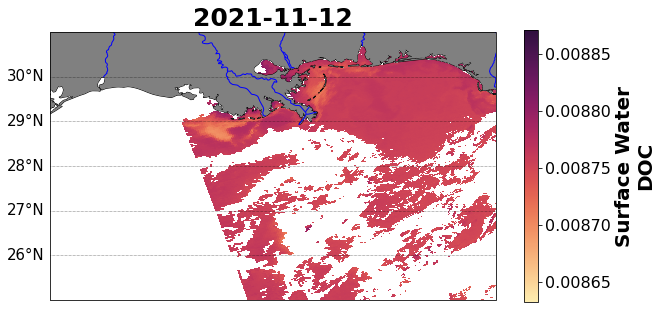

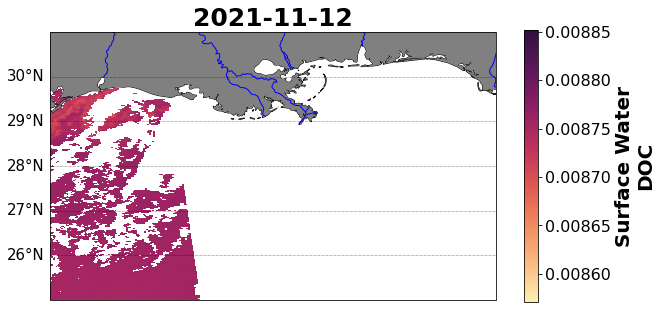

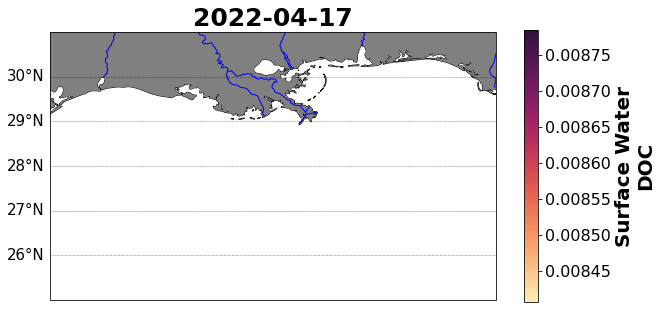

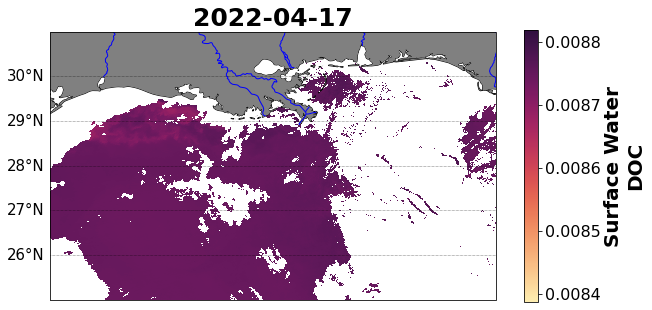

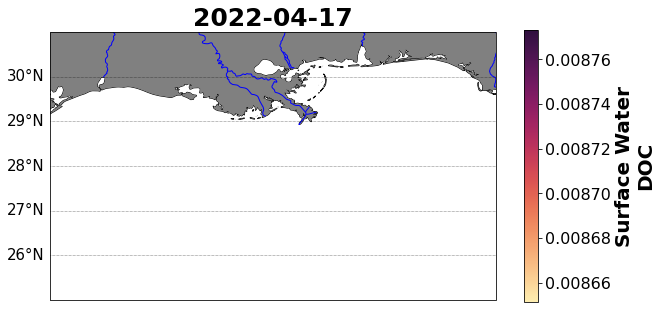

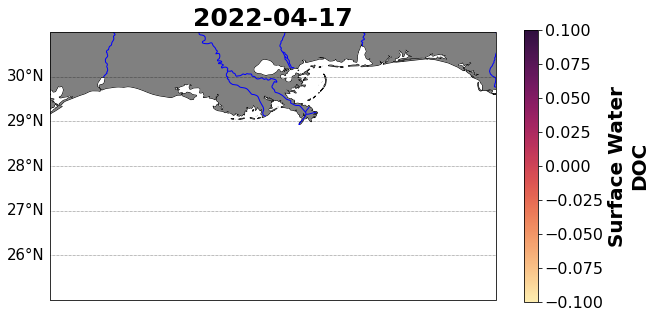

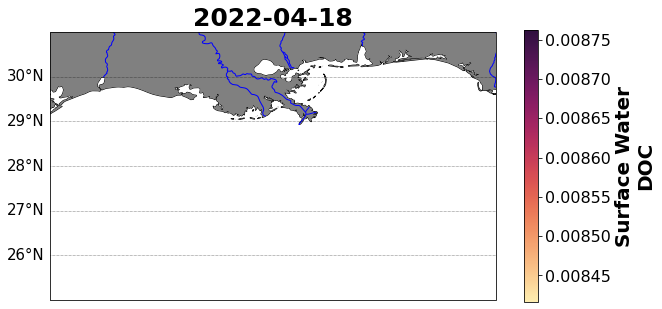

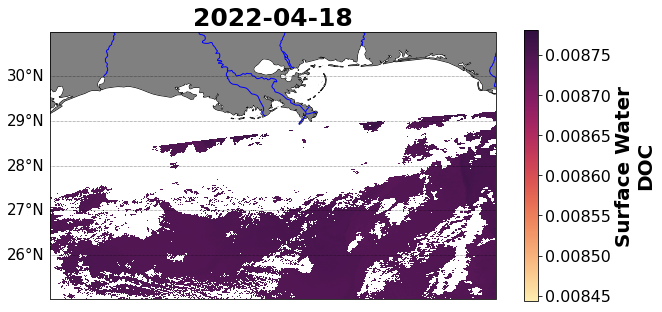

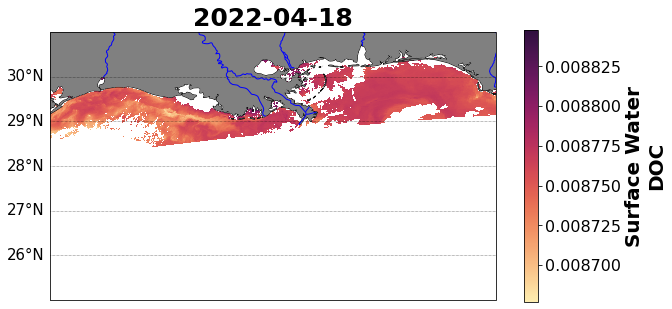

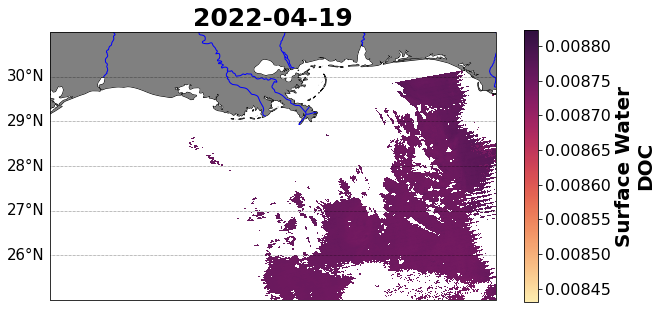

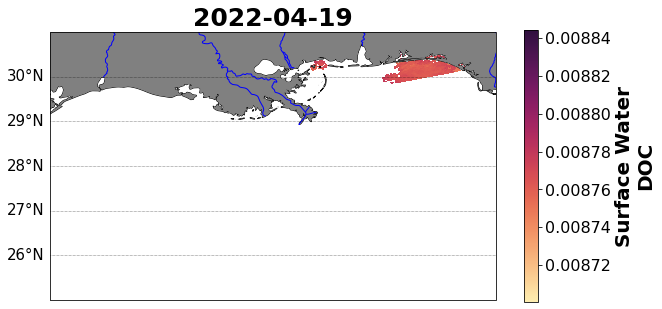

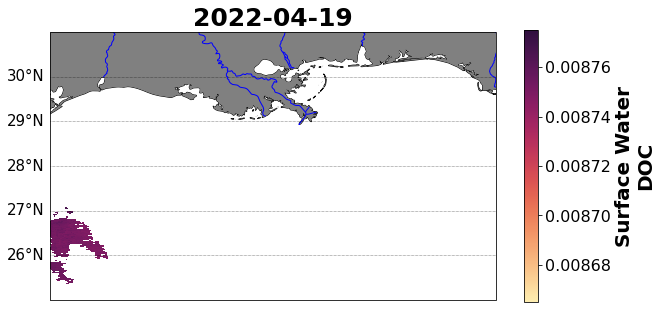

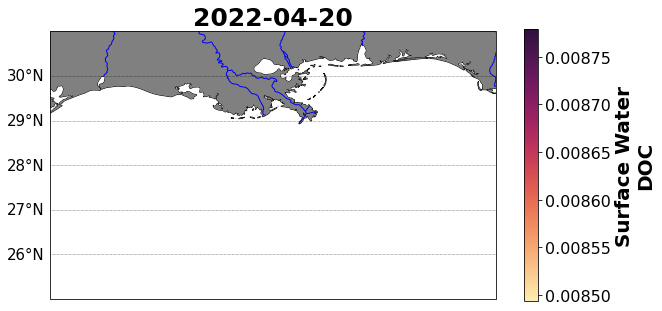

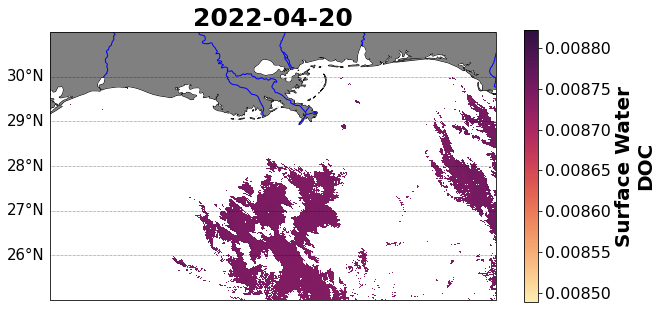

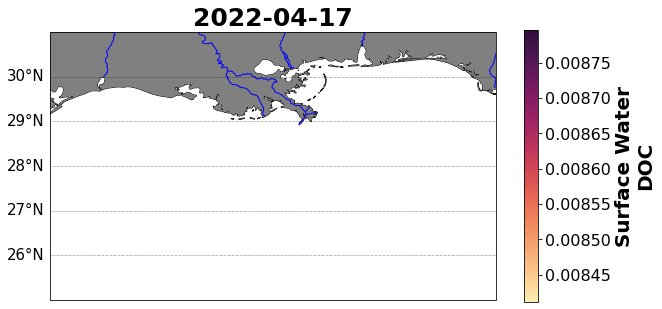

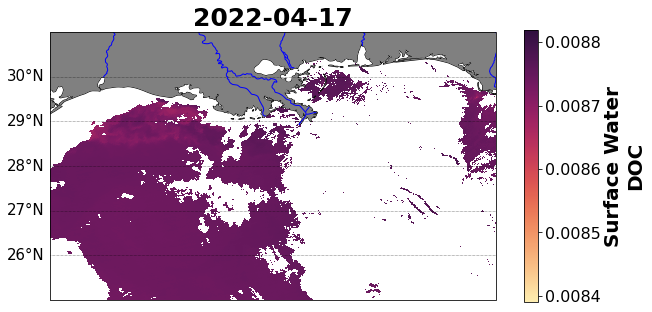

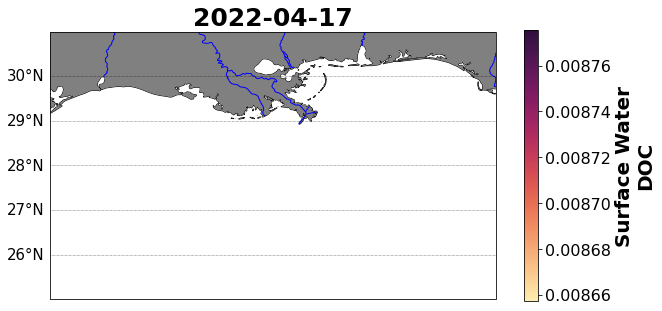

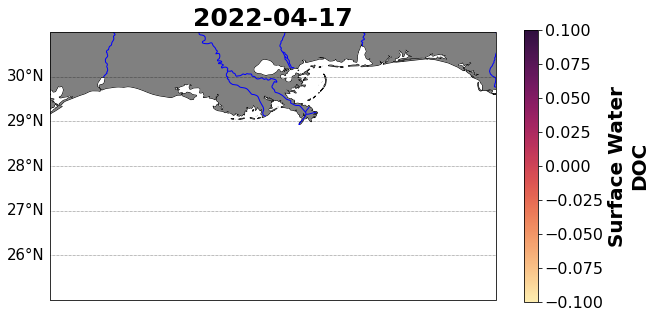

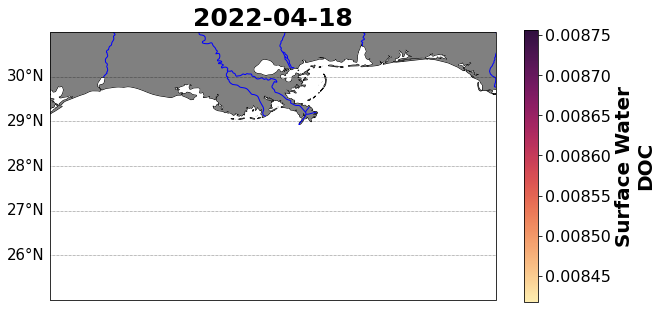

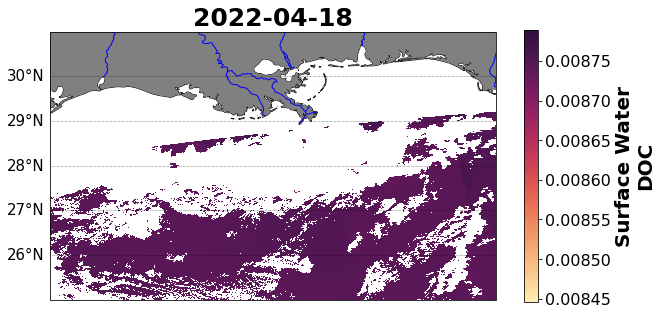

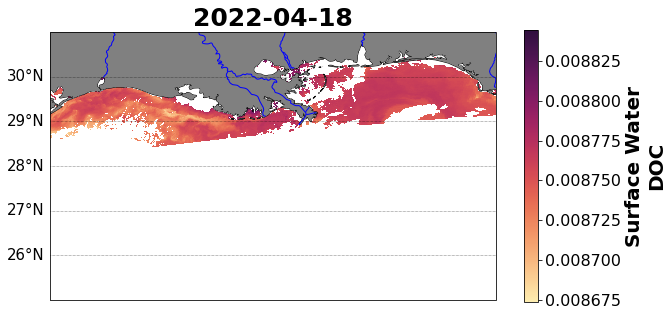

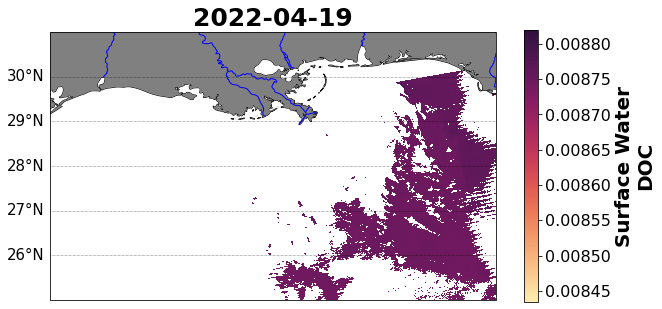

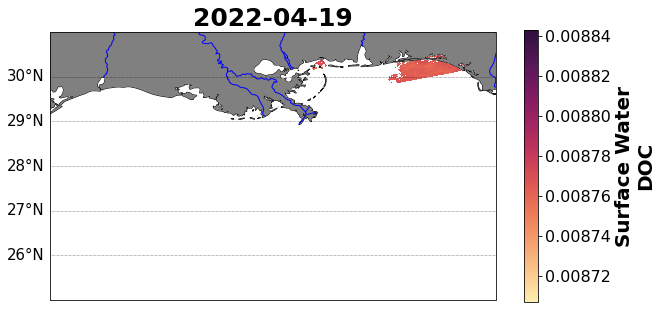

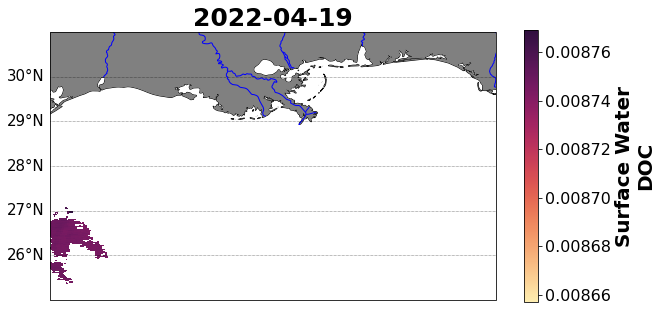

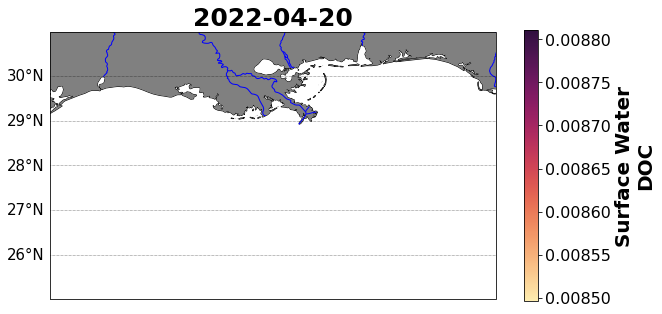

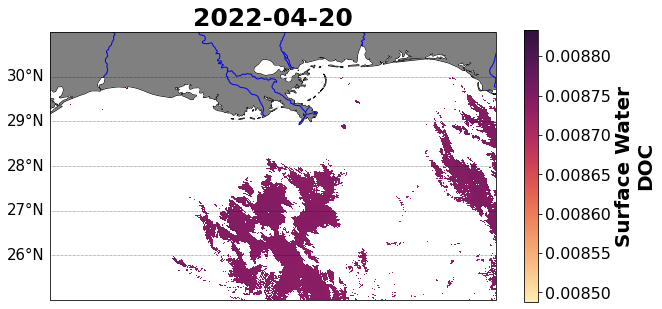

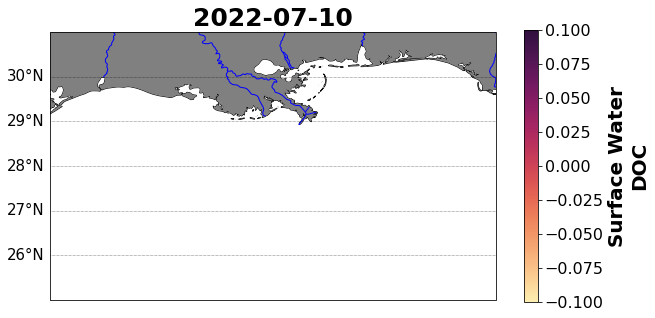

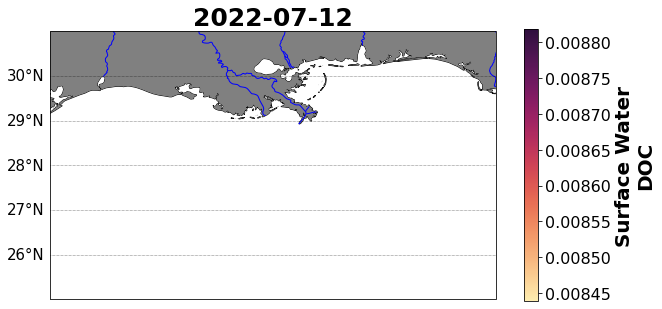

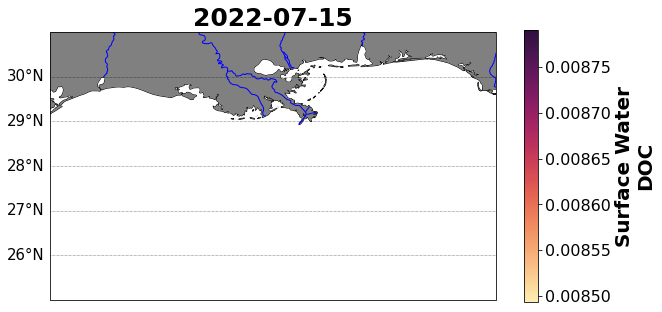

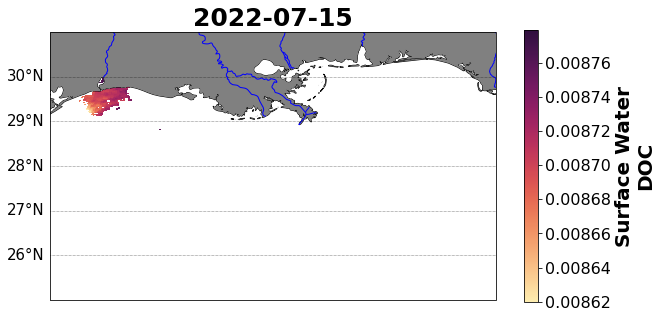

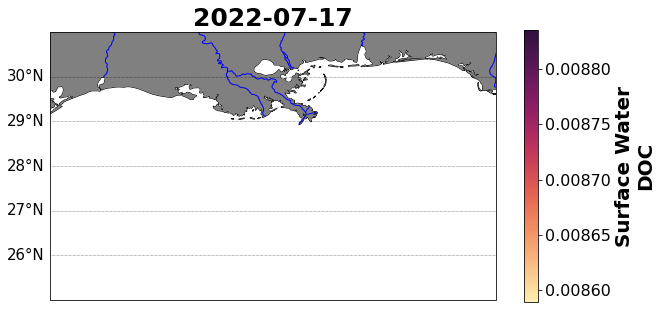

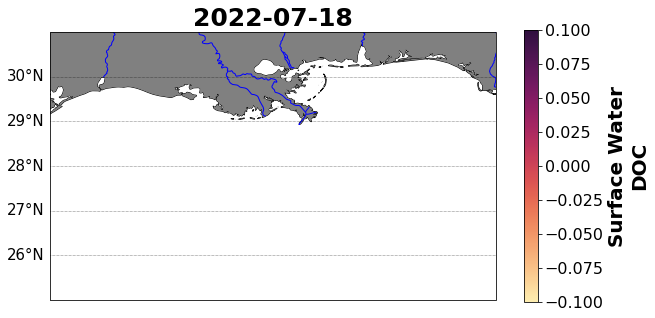

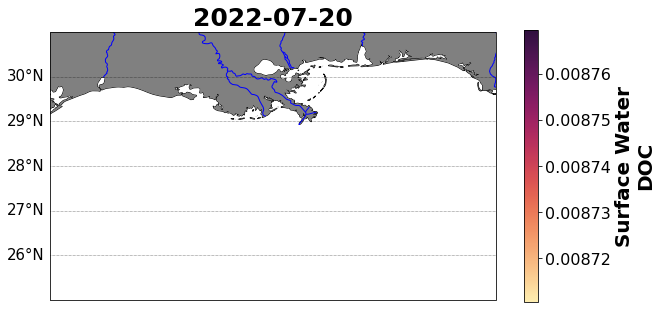

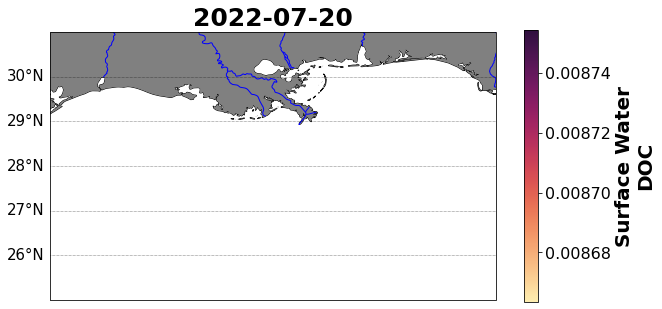

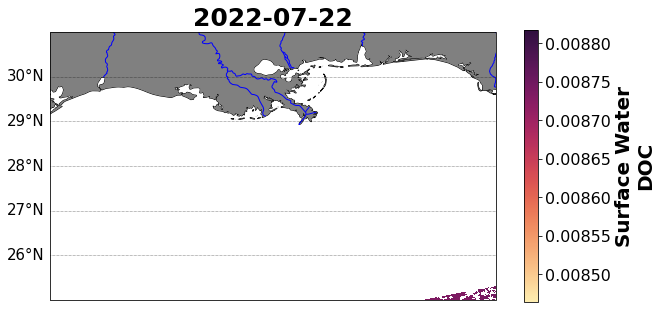

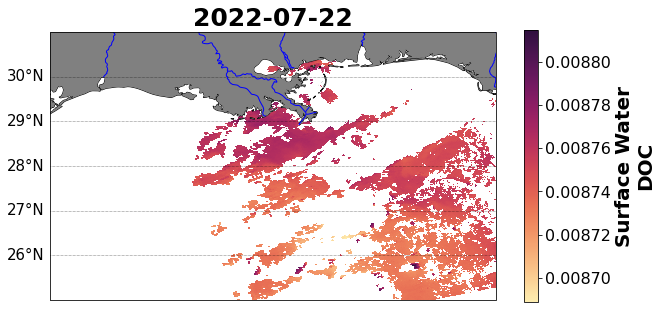

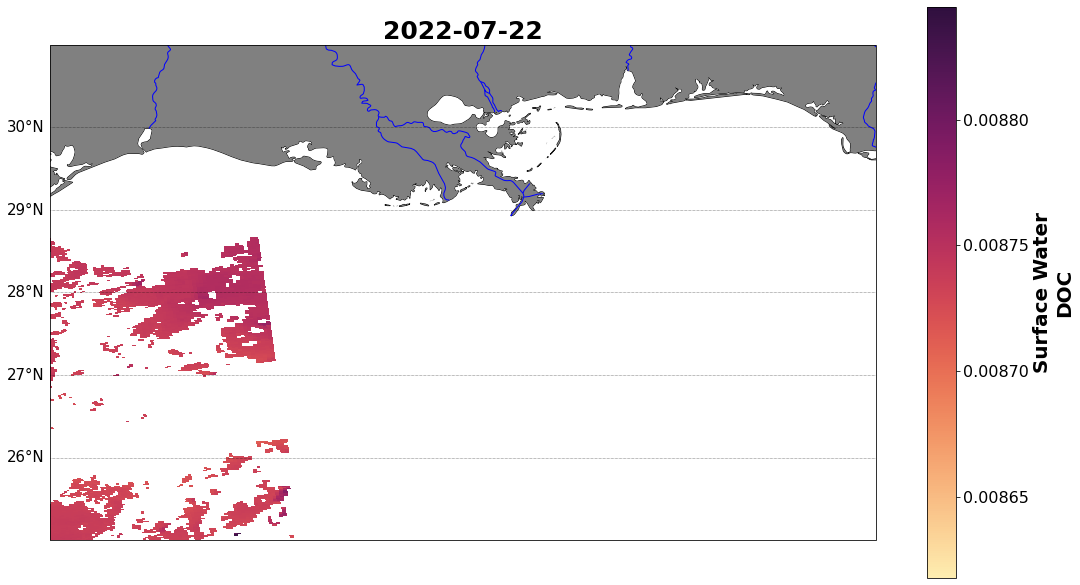

In [12]:
#make a map for all of the files 

for file in files_needed: 
    path = file 
    ds = load_satdata(path)
    ds = make_vars(ds)
    fig, ax = plot_mapbase(extent)
    satdata = ax.pcolormesh(ds['lon'], ds['lat'], ds['DOC'], cmap=cmo.matter, transform=ccrs.PlateCarree())
    cb = fig.colorbar(satdata)
    cb.ax.tick_params(labelcolor='black') 
    cb.set_label('Surface Water\n'+'DOC', size=20, weight='bold', color='black')
    tick_font_size = 16
    cb.ax.tick_params(labelsize=tick_font_size)
    ax.set_title(ds.attrs['date'], color='black', size=25, weight='bold',)
fig.set_size_inches(18.5, 10.5)

PART 2: DATA TABLES FOR COMPARISON WITH FILD OBSERVATIONS 

In [226]:
#select a file to test 
for file in files_needed: 
    path = file 
    ds = load_satdata(path)
    ds = make_vars(ds)
    lat = df[(df['Date_ST'] == ds.attrs['date'])]['Lat']
    lon = df[(df['Date_ST'] == ds.attrs['date'])]['Lon']
    lat = np.asarray(lat, dtype=float).ravel()
    lon = np.asarray(lat, dtype=float).ravel()
    lat = lat[0]
    lon = lon[0]
    
    # First, find the index of the grid point nearest a specific lat/lon.   
    abslat = np.abs(ds['lat']-lat)
    abslon = np.abs(ds['lon']-lon)
    c = np.maximum(abslon, abslat)

    ([xloc], [yloc]) = np.where(c == np.min(c))

    # Now, use that index location to get the values at the x/y diminsion
    point_ds = ds.sel(number_of_lines=xloc, pixels_per_line=yloc)
    
    aCDOM275_a = point_ds['aCDOM275_a'] 
    aCDOM333_a = point_ds['aCDOM355_a'] 
    aCDOM380_a = point_ds['aCDOM380_a'] 
    aCDOM412_a = point_ds['aCDOM412_a'] 
    aCDOM443_a = point_ds['aCDOM443_a']
    aCDOM275_b = point_ds['aCDOM275_b']
    aCDOM355_b = point_ds['aCDOM355_b']
    aCDOM380_b = point_ds['aCDOM380_b']
    aCDOM412_b = point_ds['aCDOM412_b']
    aCDOM443_b = point_ds['aCDOM443_b']
    aCDOM300 = point_ds['aCDOM300']
    aCDOM355 = point_ds['aCDOM355']
    aCDOM3ss275_295 = point_ds['aCDOMss'] 
    DOC = point_ds['DOC']
    
    df.loc[(df['Date_ST'] == ds.attrs['date']),['aCDOM275_a']] = aCDOM275_a
    
df

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  

C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  

ValueError: not enough values to unpack (expected 1, got 0)

In [14]:
path = files_needed[4]
ds = load_satdata(path)
ds = make_vars(ds)


C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)
C:\Users\12532\miniconda3\envs\Bugs\lib\site-packages\xarray\core\computation.py:727: RuntimeWarning: invalid value encountered in logaddexp
  result_data = func(*input_data)


In [15]:
ds.attrs['date'] 

'2021-10-26'

In [16]:
#lat = df['Lat']where.(df['Date_ST'] is ds.attrs['date'])
lat = df[(df['Date_ST'] == ds.attrs['date'])]['Lat']
lon = df[(df['Date_ST'] == ds.attrs['date'])]['Lon']
lat = np.asarray(lat, dtype=float).ravel()
lon = np.asarray(lat, dtype=float).ravel()
lat = lat[0]
lon = lon[0]

In [17]:
# certain lat/lon point.
#lat = df['Lat'][0]
#lon = df['Lon'][0]

# First, find the index of the grid point nearest a specific lat/lon.   
abslat = np.abs(ds['lat']-lat)
abslon = np.abs(ds['lon']-lon)
c = np.maximum(abslon, abslat)

([xloc], [yloc]) = np.where(c == np.min(c))

# Now, use that index location to get the values at the x/y diminsion
point_ds = ds.sel(number_of_lines=xloc, pixels_per_line=yloc)
point_ds

<xarray.Dataset>
Dimensions:     ()
Data variables: (12/36)
    aot_869     float32 nan
    angstrom    float32 nan
    Rrs_412     float32 nan
    Rrs_443     float32 nan
    Rrs_469     float32 nan
    Rrs_488     float32 nan
    ...          ...
    aCDOM412_b  float32 nan
    aCDOM443_b  float32 nan
    aCDOM300    float32 nan
    aCDOM355    float32 nan
    aCDOMss     float32 nan
    DOC         float32 nan
Attributes:
    time_start:  2021-10-26T19:30:01.712Z
    date:        2021-10-26

In [18]:
point_ds

<xarray.Dataset>
Dimensions:     ()
Data variables: (12/36)
    aot_869     float32 nan
    angstrom    float32 nan
    Rrs_412     float32 nan
    Rrs_443     float32 nan
    Rrs_469     float32 nan
    Rrs_488     float32 nan
    ...          ...
    aCDOM412_b  float32 nan
    aCDOM443_b  float32 nan
    aCDOM300    float32 nan
    aCDOM355    float32 nan
    aCDOMss     float32 nan
    DOC         float32 nan
Attributes:
    time_start:  2021-10-26T19:30:01.712Z
    date:        2021-10-26

In [19]:
aCDOM275_a = point_ds['aCDOM275_a'] 
aCDOM333_a = point_ds['aCDOM355_a'] 
aCDOM380_a = point_ds['aCDOM380_a'] 
aCDOM412_a = point_ds['aCDOM412_a'] 
aCDOM443_a = point_ds['aCDOM443_a']
aCDOM275_b = point_ds['aCDOM275_b']
aCDOM355_b = point_ds['aCDOM355_b']
aCDOM380_b = point_ds['aCDOM380_b']
aCDOM412_b = point_ds['aCDOM412_b']
aCDOM443_b = point_ds['aCDOM443_b']
aCDOM300 = point_ds['aCDOM300']
aCDOM355 = point_ds['aCDOM355']
aCDOM3ss275_295 = point_ds['aCDOMss'] 
DOC = point_ds['DOC']

In [20]:
#df[(df['Date_ST'] == ds.attrs['date'])]['aCDOM275_a'] = aCDOM275_a

df.loc[(df['Date_ST'] == ds.attrs['date']),['aCDOM275_a']] = aCDOM275_a

df[:40]

Sample       Date     Trip  Station        Lat        Lon  Water_dapth  \
0   222338.0 2022-04-20  GOM22SP     St.4  28.798590 -90.706616         19.0   
1   222339.0 2022-04-20  GOM22SP     St.4  28.798590 -90.706616         19.0   
2   222238.0 2022-04-19  GOM22SP    St.MK  28.907780 -90.309226         20.2   
3   222239.0 2022-04-19  GOM22SP    St.MK  28.907780 -90.309226         20.2   
4   222137.0 2022-04-18  GOM22SP    St.13  28.519041 -89.887250        577.0   
5   222138.0 2022-04-18  GOM22SP    St.13  28.519041 -89.887250        577.0   
6   222038.0 2022-04-17  GOM22SP     St.2  28.889217 -89.604540         65.0   
7   222039.0 2022-04-17  GOM22SP     St.2  28.889217 -89.604540         65.0   
8   221837.0 2022-04-16  GOM22SP    St.15  28.944220 -88.856659        267.0   
9   221838.0 2022-04-16  GOM22SP    St.15  28.944220 -88.856659        267.0   
10  221938.0 2022-04-16  GOM22SP     St.9  28.787000  89.603100         82.5   
11  221939.0 2022-04-16  GOM22SP     St.9  28.787000  89.603100         82.5   
12  221738.0 2022-04-14  GOM22SP    St.5B  28.808480 -91.334530         14.4   
13  221739.0 2022-04-14  GOM22SP    St.5B  28.808480 -91.334530         14.4   
14  221638.0 2022-04-11  GOM22SP    St.16  28.912910 -89.544833         60.0   
15  221639.0 2022-04-11  GOM22SP    St.16  28.912910 -89.544833         60.0   
16  221438.0 2022-04-10  GOM22SP     St.7  28.917243 -89.859941         39.7   
17  221539.0 2022-04-09  GOM22SP    St.14  28.726400 -89.615540         91.0   
18  215839.0 2021-11-12  GOM21FA  St.16-2  28.981788 -89.466482         16.1   
19  215840.0 2021-11-12  GOM21FA  St.16-2  28.981788 -89.466482         16.1   
20  215739.0 2021-11-10  GOM21FA    St.11  28.202903 -89.590957        934.0   
21  215740.0 2021-11-10  GOM21FA    St.11  28.202903 -89.590957        934.0   
22  215640.0 2021-11-09  GOM21FA    St.12  28.595085 -88.892108        970.0   
23  215539.0 2021-11-08  GOM21FA    St.16  28.888246 -89.541178         58.2   
24  215540.0 2021-11-08  GOM21FA    St.16  28.888246 -89.541178         58.2   
25  215440.0 2021-11-07  GOM21FA    St.13  28.528555 -89.609013        464.0   
26  215239.0 2021-11-02  GOM21FA    St.15  28.948919 -88.849900        264.9   
27  215240.0 2021-11-02  GOM21FA    St.15  28.948919 -88.849900        264.9   
28  215339.0 2021-11-02  GOM21FA     St.2  28.898021 -89.602153         62.5   
29  215340.0 2021-11-02  GOM21FA     St.2  28.898021 -89.602153         62.5   
30  215040.0 2021-11-01  GOM21FA     St.9  28.785411 -89.597605         80.6   
31  215139.0 2021-11-01  GOM21FA  St.14.5  28.839486 -89.239491        105.0   
32  215140.0 2021-11-01  GOM21FA  St.14.5  28.839486 -89.239491        105.0   
33  214939.0 2021-10-31  GOM21FA    St.14  28.726274 -89.621910         88.6   
34  214940.0 2021-10-31  GOM21FA    St.14  28.726274 -89.621910         88.6   
35  214539.0 2021-10-27  GOM21FA     St.4  28.795840 -90.703130         16.5   
36  214540.0 2021-10-27  GOM21FA     St.4  28.795840 -90.703130         16.5   
37  214339.0 2021-10-25  GOM21FA    St.5B  28.806587 -91.335981         12.3   
38  214340.0 2021-10-25  GOM21FA    St.5B  28.806587 -91.335981         12.3   
39  225333.0 2022-07-23  GOM22SU    St.MK        NaN        NaN         17.5   

    Sample_depth                                              Notes  Flagged  \
0            0.0  Misslables as MK on the bag. But the sample nu...      NaN   
1            0.0  Misslables as MK on the bag. But the sample nu...      NaN   
2            0.0                                                NaN      NaN   
3            0.0                                                NaN      NaN   
4            0.0                                                NaN      NaN   
5            0.0                                                NaN      NaN   
6            0.0                                                NaN      NaN   
7            0.0                                                NaN      NaN   
8    

EXTRA